In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from lightgbm import LGBMRegressor
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.multioutput import MultiOutputRegressor
import warnings
import seaborn as sns
import os

warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# ==========================================
# 기초 함수 및 강화된 피처 엔지니어링 정의
# ==========================================

def add_all_year_holiday_features(data):
    #기념일 및 명절 리스트화
    def get_flower_holidays(year):
        
        holidays = {
            'Graduation': pd.to_datetime(f'{year}-02-10'),
            'Valentine': pd.to_datetime(f'{year}-02-14'),
            'WhiteDay': pd.to_datetime(f'{year}-03-14'),
            'ParentsDay': pd.to_datetime(f'{year}-05-08'),
            'TeachersDay': pd.to_datetime(f'{year}-05-15'),
            'Christmas': pd.to_datetime(f'{year}-12-25')
        }
        
        lunar_map = {
            2019: {'Seollal': '02-05', 'Chuseok': '09-13'},
            2020: {'Seollal': '01-25', 'Chuseok': '10-01'},
            2021: {'Seollal': '02-12', 'Chuseok': '09-21'},
            2022: {'Seollal': '02-01', 'Chuseok': '09-10'},
            2023: {'Seollal': '01-22', 'Chuseok': '09-29'},
            2024: {'Seollal': '02-10', 'Chuseok': '09-17'},
            2025: {'Seollal': '01-29', 'Chuseok': '10-06'},
            2026: {'Seollal': '02-17', 'Chuseok': '09-25'}
        }
        
        if year in lunar_map:
            for name, date in lunar_map[year].items():
                holidays[name] = pd.to_datetime(f'{year}-{date}')
            
        return holidays
        
    # 리스트해준 holidays들을 반영하여 가중치 적용
    def calculate_min_dist(row):
        curr = row['date']
        hols = list(get_flower_holidays(curr.year).values()) + list(get_flower_holidays(curr.year + 1).values())
        future = [h for h in hols if h >= curr]
        if not future: return 0
        
        dist = (min(future) - curr).days
        
        if dist <= 14:
            # 제곱법을 이용한 '임박 신호' 줌
            return float((14 - dist) ** 2) 
        return 0.0
        
    data['holiday_impact'] = data.apply(calculate_min_dist, axis=1)
    return data

def engineer_features(df):
    epsilon = 1e-6
    
    # 시장 구조 피처
    df["spread"] = df["max_amount"] - df["min_amount"]
    df["premium_ratio"] = df["max_amount"] / (df["mean"] + epsilon)
    df["low_pressure"] = df["mean"] - df["min_amount"]

    # 물량 흐름 피처
    df['next_auction_qty'] = df['total_quantity'].shift(-1)
    df['next_auction_qty'] = df['next_auction_qty'].fillna(df['total_quantity'].mean())
    df["next_qty_change_ratio"] = (df["next_auction_qty"] - df["total_quantity"]) / (df["total_quantity"] + epsilon)

    # 시계열 추세 및 날짜 정보
    df["mean_roll7_mean"] = df["mean"].rolling(7).mean()
    df["qty_roll7_mean"] = df["total_quantity"].rolling(7).mean()

    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    
    # 명절 엔진 적용 (설날/추석)
    df = add_all_year_holiday_features(df)
    
    df = df.fillna(method='bfill').fillna(0)
    
    # 로그 변환: 이상치 억제용도, 소위 말하는 '철'에 그래프가 솟구치는 것 감안
    # log1p는 데이터에 0이 포함된 경우 에러 방지
    log_cols = ['max_amount', 'mean', 'min_amount', 'spread', 'total_quantity', 'next_auction_qty']
    for col in log_cols:
        df[f'log_{col}'] = np.log1p(df[col])
        
    return df

In [7]:
# ==========================================
# 데이터 로드 및 연속형 멀티 타겟 데이터셋 생성
# ==========================================

# file_name = '19_25_Q1freesia_sol.CSV'
# file_name = '19_25_Q2freesia_sol.CSV'
# file_name = '19_25_Q3chrysanthemum_pode.CSV'
# file_name = '19_25_Q4chrysanthemum_pode.csv
base_path = '../data/' #데이터파일이 경로
file_name = '19_25_Q4chrysanthemum_pode.csv'

full_path = os.path.join(base_path, file_name)

print(f"로드 중인 파일: {full_path}")

df = pd.read_csv(full_path)
display(df.head())

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df['year'] = df['date'].dt.year
df['auction_count'] = df.groupby('year').cumcount() + 1

df_std = engineer_features(df)
min_rounds = df_std[df_std['year'] <= 2024].groupby('year')['auction_count'].max().min()
df_std = df_std[df_std['auction_count'] <= min_rounds].copy()

# 학습 피처 리스트
features = [
    'log_total_quantity', 'log_next_auction_qty', 'next_qty_change_ratio',
    'log_max_amount', 'log_mean', 'log_min_amount', 'log_spread', 
    'premium_ratio', 'low_pressure', 'mean_roll7_mean', 'qty_roll7_mean',
    'holiday_impact', 'auction_count', 'month', 'dayofweek'
]

로드 중인 파일: ../data/19_25_Q4chrysanthemum_pode.csv


,date,total_quantity,total_amount,max_amount,min_amount,mean
0,2019-10-02,2632,5223880,2980,1250,1985
1,2019-10-04,3642,6835590,3200,1000,1877
2,2019-10-07,3766,6352470,2530,1000,1687
3,2019-10-09,2619,4200120,2450,1000,1604
4,2019-10-10,40,40000,1000,1000,1000


C:\Users\ktg08\AppData\Local\Temp\ipykernel_21460\753353762.py:75: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(0)


In [8]:
# 윈도우 슬라이딩을 이용한 학습할 타겟 데이터 접근 함수 정의 
def create_continuous_multi_target_dataset(data, window, steps, features):
    X, y, years, rounds = [], [], [], []
    for i in range(len(data) - window - steps + 1):
        X.append(data[features].iloc[i : i + window].values.flatten())
        y_min = data['log_min_amount'].iloc[i + window : i + window + steps].values
        y_mean = data['log_mean'].iloc[i + window : i + window + steps].values
        y_max = data['log_max_amount'].iloc[i + window : i + window + steps].values
        y.append(np.concatenate([y_min, y_mean, y_max]))
        years.append(data['year'].iloc[i + window])
        rounds.append(data['auction_count'].iloc[i + window])
    return np.array(X), np.array(y), np.array(years), np.array(rounds)

In [9]:
window_size, future_steps = 3, 7
X_raw, y_raw, year_indices, round_indices = create_continuous_multi_target_dataset(df_std, window_size, future_steps, features)

flat_feature_names = [f"{f}_lag{lag}" for lag in range(window_size, 0, -1) for f in features]
X_final_df = pd.DataFrame(X_raw, columns=flat_feature_names)

# 학습 데이터와 테스트 데이터 분리
X_train, y_train = X_final_df[year_indices <= 2024], y_raw[year_indices <= 2024]
X_test, y_test = X_final_df[year_indices == 2025], y_raw[year_indices == 2025]
test_rounds = round_indices[year_indices == 2025]

# 모델 학습 (3중 타겟)
# ==========================================

lgbm = LGBMRegressor(n_estimators=500, 
                     learning_rate=0.01, 
                     num_leaves=15, 
                     max_depth=5,
                     random_state=42, 
                     verbose=-1)
model = MultiOutputRegressor(lgbm)
model.fit(X_train, y_train)

,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.,"LGBMRegressor...2, verbose=-1)"
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",None
,boosting_type,'gbdt'
,num_leaves,15
,max_depth,5
,learning_rate,0.01
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0


[2025 TEST] MAPE
학습 파일: 19_25_Q4chrysanthemum_pode.csv
- Min: 23.30% | Mean: 16.46% | Max: 14.56%


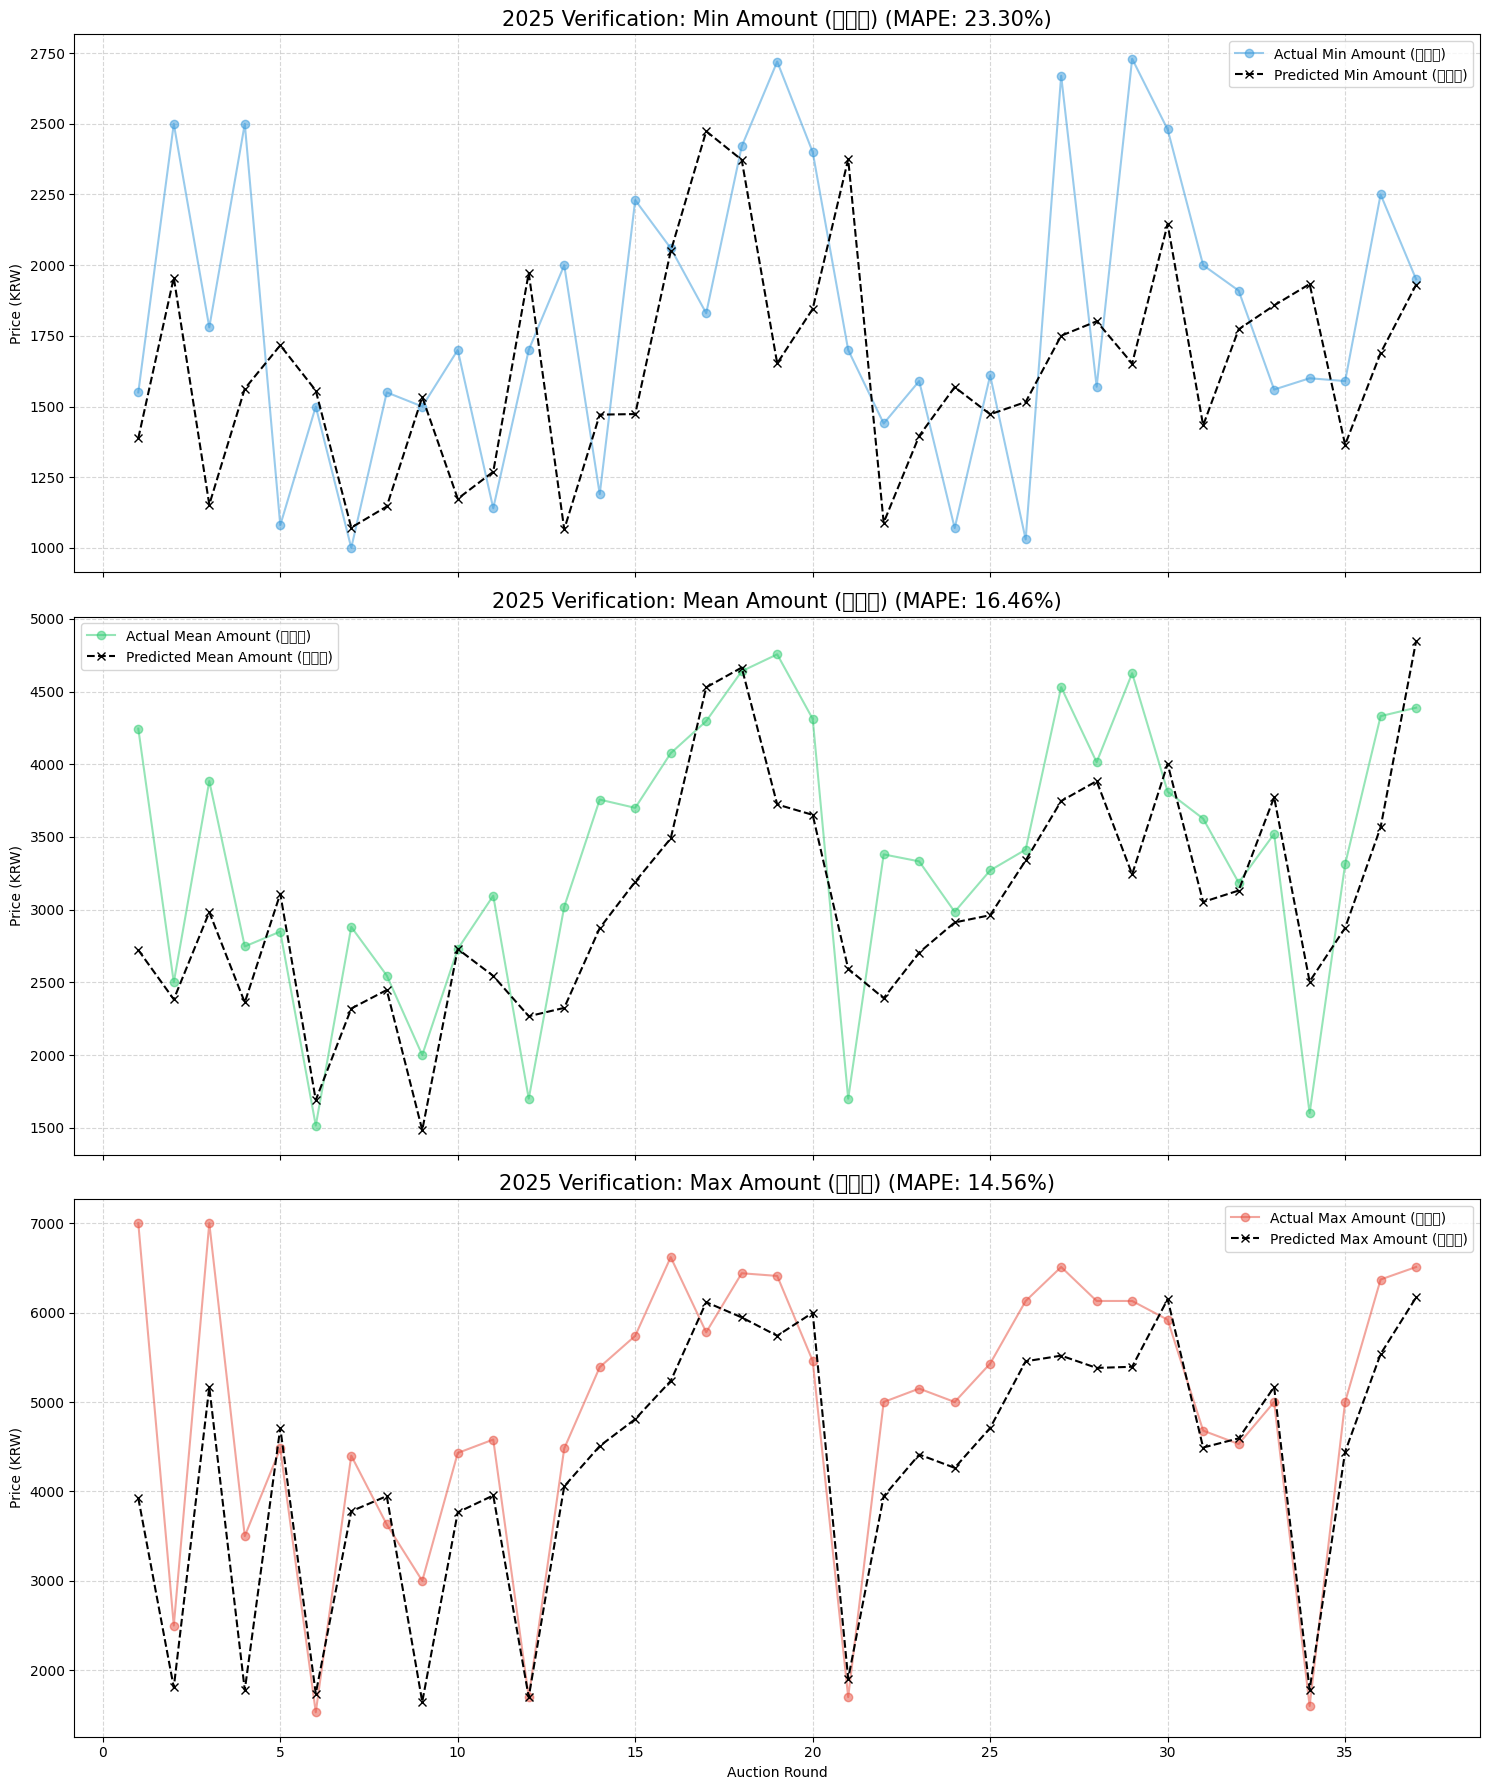

--- [2025년 모델 검증 지표 요약] ---
1. 최저가(Min) MAPE: 23.30%
2. 평균가(Mean) MAPE: 16.46%
3. 최고가(Max) MAPE: 14.56%
--- [2025년 회차별 상세 검증표 (상위 15회차)] ---


,Round,Actual_Min,Pred_Min,Min_Error,Min_MAPE(%),Actual_Mean,Pred_Mean,Mean_Error,Mean_MAPE(%),Actual_Max,Pred_Max,Max_Error,Max_MAPE(%)
0,1,1550,1387,162,10.47,4245,2722,1522,35.87,6999,3925,3074,43.92
1,2,2500,1955,544,21.77,2500,2383,116,4.68,2500,1807,692,27.69
2,3,1779,1153,626,35.21,3884,2983,900,23.20,6999,5164,1835,26.22
3,4,2500,1563,936,37.48,2746,2361,385,14.04,3499,1777,1722,49.21
4,5,1079,1716,-636,58.94,2848,3109,-260,9.14,4479,4709,-229,5.13
5,6,1499,1556,-56,3.76,1515,1690,-175,11.55,1530,1739,-209,13.69
6,7,999,1071,-71,7.17,2880,2319,561,19.48,4399,3778,621,14.13
7,8,1550,1146,403,26.04,2547,2447,99,3.92,3629,3947,-317,8.75
8,9,1499,1533,-33,2.24,2000,1483,516,25.81,2999,1646,1353,45.13
9,10,1700,1173,526,30.96,2729,2729,0,0.02,4430,3765,664,15.00



--- [지표별 평균 오차 범위 요약] ---


,Indicator,Avg_Actual,Avg_Error,Overall_MAPE(%)
0,Min,1813.51,424.86,23.30
1,Mean,3358.86,517.86,16.46
2,Max,4888.11,706.95,14.56


In [10]:
#2025년 테스트 데이터 검증 
# ==========================================

# **** 1회차 시드 계산 (최근 연도 가중치 반영 가능)
historical_r1 = df_std[(df_std['year'] < 2025) & (df_std['auction_count'] == 1)].copy()

# 최근 연도(2024)에 가중치 2.0 부여 (선택 사항) -> 여기서 가중치는 단순 물가 감안한 임의값
historical_r1['weight'] = historical_r1['year'].apply(lambda x: 2.0 if x == 2024 else 1.0)

# 가중 평균 함수 (안정적인 시드 값 도출)
def get_weighted_seed(df, col):
    return np.expm1(np.average(df[col], weights=df['weight']))

# 시드값 산출
r1_seed_min = get_weighted_seed(historical_r1, 'log_min_amount')
r1_seed_mean = get_weighted_seed(historical_r1, 'log_mean') 
r1_seed_max = get_weighted_seed(historical_r1, 'log_max_amount')

# 2025년 데이터 배치 예측
y_pred_log_test = model.predict(X_test)

# Reshape (샘플 수, 지표 3개, 미래 7일)
y_test_res = y_test.reshape(-1, 3, future_steps)
y_pred_res = y_pred_log_test.reshape(-1, 3, future_steps)

# 바로 다음 날(Step 0) 예측값 추출 및 역로그 변환
actual_min, actual_mean, actual_max = np.expm1(y_test_res[:, 0, 0]), np.expm1(y_test_res[:, 1, 0]), np.expm1(y_test_res[:, 2, 0])
pred_min, pred_mean, pred_max = np.expm1(y_pred_res[:, 0, 0]), np.expm1(y_pred_res[:, 1, 0]), np.expm1(y_pred_res[:, 2, 0])

# 1회차 데이터 보정
is_round_1 = (test_rounds == 1)
pred_min[is_round_1] = r1_seed_min
pred_mean[is_round_1] = r1_seed_mean
pred_max[is_round_1] = r1_seed_max

# MAPE 계산 (안전한 나눗셈)
def calculate_mape(actual, pred):
    mask = actual > 0 # 실제값이 0인 경우 제외 (계산 오류 방지)
    return np.mean(np.abs((actual[mask] - pred[mask]) / actual[mask])) * 100

mape_min = calculate_mape(actual_min, pred_min)
mape_mean = calculate_mape(actual_mean, pred_mean)
mape_max = calculate_mape(actual_max, pred_max)

print(f"[2025 TEST] MAPE")
print(f"학습 파일: {file_name}")
print(f"- Min: {mape_min:.2f}% | Mean: {mape_mean:.2f}% | Max: {mape_max:.2f}%")

# 최고가, 최저가, 평균가 지표 비교 그래프
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
titles = ['Min Amount (최저가)', 'Mean Amount (평균가)', 'Max Amount (최고가)']
actuals = [actual_min, actual_mean, actual_max]
preds = [pred_min, pred_mean, pred_max]
colors = ['#3498db', '#2ecc71', '#e74c3c'] # Blue, Green, Red
mapes = [mape_min, mape_mean, mape_max]

for i in range(3):
    axes[i].plot(test_rounds, actuals[i], 'o-', label=f'Actual {titles[i]}', color=colors[i], alpha=0.5)
    axes[i].plot(test_rounds, preds[i], 'x--', label=f'Predicted {titles[i]}', color='black', linewidth=1.5)
    
    axes[i].set_title(f"2025 Verification: {titles[i]} (MAPE: {mapes[i]:.2f}%)", fontsize=15)
    axes[i].set_ylabel("Price (KRW)")
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Auction Round")
plt.tight_layout()
plt.show()

# 지표 요약 출력
print("--- [2025년 모델 검증 지표 요약] ---")
print(f"1. 최저가(Min) MAPE: {mape_min:.2f}%")
print(f"2. 평균가(Mean) MAPE: {mape_mean:.2f}%")
print(f"3. 최고가(Max) MAPE: {mape_max:.2f}%")

# [상세 표] 2025년 실제 vs 예측값 비교 및 오차 분석
# ==========================================

# 데이터 프레임 생성을 위한 딕셔너리
validation_summary = {
    'Round': test_rounds,
    
    # 최저가 (Min)
    'Actual_Min': actual_min.astype(int),
    'Pred_Min': pred_min.astype(int),
    'Min_Error': (actual_min - pred_min).astype(int),
    'Min_MAPE(%)': (np.abs(actual_min - pred_min) / (actual_min + 1e-6) * 100).round(2),
    
    # 평균가 (Mean)
    'Actual_Mean': actual_mean.astype(int),
    'Pred_Mean': pred_mean.astype(int),
    'Mean_Error': (actual_mean - pred_mean).astype(int),
    'Mean_MAPE(%)': (np.abs(actual_mean - pred_mean) / (actual_mean + 1e-6) * 100).round(2),
    
    # 최고가 (Max)
    'Actual_Max': actual_max.astype(int),
    'Pred_Max': pred_max.astype(int),
    'Max_Error': (actual_max - pred_max).astype(int),
    'Max_MAPE(%)': (np.abs(actual_max - pred_max) / (actual_max + 1e-6) * 100).round(2)
}

# 데이터프레임 생성
df_validation_detail = pd.DataFrame(validation_summary)

# 전체 평균 오차범위 계산
error_bounds = {
    'Indicator': ['Min', 'Mean', 'Max'],
    'Avg_Actual': [actual_min.mean(), actual_mean.mean(), actual_max.mean()],
    'Avg_Error': [
        np.abs(df_validation_detail['Min_Error']).mean(),
        np.abs(df_validation_detail['Mean_Error']).mean(),
        np.abs(df_validation_detail['Max_Error']).mean()
    ],
    'Overall_MAPE(%)': [mape_min, mape_mean, mape_max]
}
df_error_summary = pd.DataFrame(error_bounds)

# 결과 출력
print("--- [2025년 회차별 상세 검증표 (상위 15회차)] ---")
display(df_validation_detail.head(15))

print("\n--- [지표별 평균 오차 범위 요약] ---")
display(df_error_summary.round(2))

In [12]:
# ==========================================
# 2026년 재귀적 예측 (Recursive Simulation)
# ==========================================
kr_holidays_2026 = [
    '2026-01-01', '2026-02-16', '2026-02-17', '2026-02-18', 
    '2026-03-02', '2026-05-05', '2026-05-25', '2026-08-17', 
    '2026-09-24', '2026-09-25', '2026-09-26', '2026-09-28', 
    '2026-10-05', '2026-10-09', '2026-12-25'
]

base_date = df['date'].min()
start_month = base_date.month
start_day = base_date.day
start_date_2026 = pd.to_datetime(f'2026-{start_month:02d}-{start_day:02d}')


auc_cal_2026 = CustomBusinessDay(weekmask='Mon Wed Fri', holidays=kr_holidays_2026)
last_date = df_std['date'].max()

#물가 고려한 가중치
market_trend_coeff = 1.42

# 만약 2025년 4분기 데이터가 끝났다면, 자동으로 2026년 4분기 혹은 다음 경매일로 넘어감.
print(f"시뮬레이션 시작일: {start_date_2026}")
# 회차별 평균 물량
avg_qty_by_round = df_std.groupby('auction_count')['total_quantity'].mean()

# 시작 윈도우: 과거 19~25년 모든 '시즌 초반(1~3회차)'의 평균 상태
# 2025년 4월 데이터가 아닌, 과거 시즌 초반(1~3회차) 데이터를 사용하되 최근 데이터에 2배 가중치
early_season = df_std[df_std['auction_count'].isin([1, 2, 3])].copy()
early_season['weight'] = early_season['year'].apply(lambda x: 2.0 if x >= 2024 else 1.0)

weighted_stats = early_season.apply(lambda x: np.average(x, weights=early_season['weight']) if x.name in features else x.mean())
initial_seed = weighted_stats[features].values.tolist()
current_x = initial_seed * window_size

# 시뮬레이션 실행
avg_qty_by_round = df_std.groupby('auction_count')['total_quantity'].mean()
forecast_2026 = []

# ==========================================
forecast_2026 = []
# 현재 윈도우 초기화 (이미 정의된 initial_seed 사용)
current_x = initial_seed * window_size

for r in range(1, min_rounds + 1):
    X_input = pd.DataFrame([current_x], columns=flat_feature_names)
    pred_log = model.predict(X_input)[0]
    
    # 결과 계산 및 가중치(market_trend_coeff) 적용
    curr_date = start_date_2026 + ((r-1) * auc_cal_2026)
    
    # 원본 예측치에 시장 트렌드 계수 곱셈
    p_min = np.expm1(pred_log[0]) * market_trend_coeff
    p_mean = np.expm1(pred_log[7]) * market_trend_coeff
    p_max = np.expm1(pred_log[14]) * market_trend_coeff
    
    forecast_2026.append({
        'date': curr_date, 
        'auction_count': r,
        'min': p_min, 
        'mean': p_mean, 
        'max': p_max
    })
    
    # 다음 회차를 위한 윈도우 업데이트 로직
    if r < min_rounds:
        next_date = start_date_2026 + (r * auc_cal_2026)
        curr_qty = avg_qty_by_round.get(r, avg_qty_by_round.mean())
        next_qty = avg_qty_by_round.get(r+1, avg_qty_by_round.mean())
        
        # 피처 업데이트용 로그값 (입력용이므로 원본 pred_log 사용 권장)
        # 또는 보정된 값을 다시 로그화하여 주입 가능
        l_min, l_mean, l_max = pred_log[0], pred_log[7], pred_log[14]
        tmp_impact = add_all_year_holiday_features(pd.DataFrame({'date': [next_date]}))['holiday_impact'].iloc[0]
        
        next_row = [
            np.log1p(curr_qty), np.log1p(next_qty), (next_qty - curr_qty)/(curr_qty + 1e-6),
            l_max, l_mean, l_min, np.log1p(np.expm1(l_max)-np.expm1(l_min)),
            np.expm1(l_max)/(np.expm1(l_mean)+1e-6), np.expm1(l_mean)-np.expm1(l_min),
            l_mean, np.log1p(curr_qty), tmp_impact, r+1, next_date.month, next_date.dayofweek
        ]
        current_x = current_x[len(features):] + next_row

df_2026 = pd.DataFrame(forecast_2026)

시뮬레이션 시작일: 2026-10-02 00:00:00


--- [2025년 회차별 상세 검증표 (상위 15회차)] ---


,Round,Actual_Min,Pred_Min,Min_Error,Min_MAPE(%),Actual_Mean,Pred_Mean,Mean_Error,Mean_MAPE(%),Actual_Max,Pred_Max,Max_Error,Max_MAPE(%)
0,1,1550,1387,162,10.47,4245,2722,1522,35.87,6999,3925,3074,43.92
1,2,2500,1955,544,21.77,2500,2383,116,4.68,2500,1807,692,27.69
2,3,1779,1153,626,35.21,3884,2983,900,23.20,6999,5164,1835,26.22
3,4,2500,1563,936,37.48,2746,2361,385,14.04,3499,1777,1722,49.21
4,5,1079,1716,-636,58.94,2848,3109,-260,9.14,4479,4709,-229,5.13
5,6,1499,1556,-56,3.76,1515,1690,-175,11.55,1530,1739,-209,13.69
6,7,999,1071,-71,7.17,2880,2319,561,19.48,4399,3778,621,14.13
7,8,1550,1146,403,26.04,2547,2447,99,3.92,3629,3947,-317,8.75
8,9,1499,1533,-33,2.24,2000,1483,516,25.81,2999,1646,1353,45.13
9,10,1700,1173,526,30.96,2729,2729,0,0.02,4430,3765,664,15.00



--- [지표별 평균 오차 범위 요약] ---


,Indicator,Avg_Actual,Avg_Error,Overall_MAPE(%)
0,Min,1813.51,424.86,23.30
1,Mean,3358.86,517.86,16.46
2,Max,4888.11,706.95,14.56


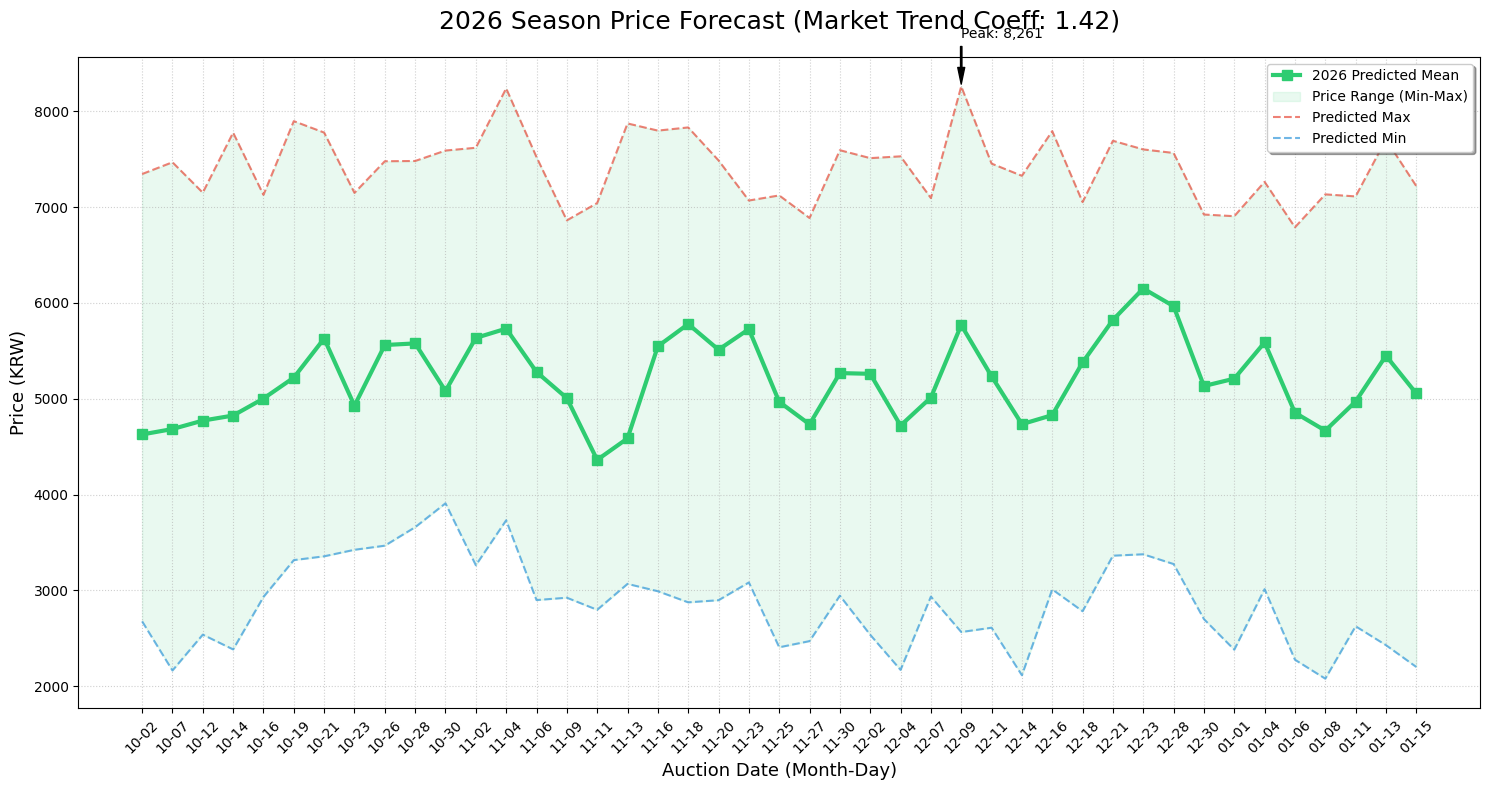

,date,auction_count,min,mean,max
0,2026-10-02,1,2677.179524,4627.833562,7345.813775
1,2026-10-07,2,2164.219251,4684.233119,7468.740248
2,2026-10-12,3,2538.335498,4772.400227,7151.263823
3,2026-10-14,4,2384.178298,4825.184577,7777.618727
4,2026-10-16,5,2931.811580,5002.492986,7128.589452
5,2026-10-19,6,3316.263495,5221.014724,7897.800439
6,2026-10-21,7,3356.043059,5629.062522,7778.527592
7,2026-10-23,8,3424.098862,4927.524952,7149.231830
8,2026-10-26,9,3466.882259,5561.167919,7479.307282
9,2026-10-28,10,3659.944875,5578.036302,7482.038361


In [13]:
# [상세 표] 2025년 실제 vs 예측값 비교 및 오차 분석
# ==========================================

# 데이터 프레임 생성을 위한 딕셔너리
validation_summary = {
    'Round': test_rounds,
    
    # 최저가 (Min)
    'Actual_Min': actual_min.astype(int),
    'Pred_Min': pred_min.astype(int),
    'Min_Error': (actual_min - pred_min).astype(int),
    'Min_MAPE(%)': (np.abs(actual_min - pred_min) / (actual_min + 1e-6) * 100).round(2),
    
    # 평균가 (Mean)
    'Actual_Mean': actual_mean.astype(int),
    'Pred_Mean': pred_mean.astype(int),
    'Mean_Error': (actual_mean - pred_mean).astype(int),
    'Mean_MAPE(%)': (np.abs(actual_mean - pred_mean) / (actual_mean + 1e-6) * 100).round(2),
    
    # 최고가 (Max)
    'Actual_Max': actual_max.astype(int),
    'Pred_Max': pred_max.astype(int),
    'Max_Error': (actual_max - pred_max).astype(int),
    'Max_MAPE(%)': (np.abs(actual_max - pred_max) / (actual_max + 1e-6) * 100).round(2)
}

# 데이터프레임 생성
df_validation_detail = pd.DataFrame(validation_summary)

# 전체 평균 오차범위 계산
error_bounds = {
    'Indicator': ['Min', 'Mean', 'Max'],
    'Avg_Actual': [actual_min.mean(), actual_mean.mean(), actual_max.mean()],
    'Avg_Error': [
        np.abs(df_validation_detail['Min_Error']).mean(),
        np.abs(df_validation_detail['Mean_Error']).mean(),
        np.abs(df_validation_detail['Max_Error']).mean()
    ],
    'Overall_MAPE(%)': [mape_min, mape_mean, mape_max]
}
df_error_summary = pd.DataFrame(error_bounds)

# 결과 출력
print("--- [2025년 회차별 상세 검증표 (상위 15회차)] ---")
display(df_validation_detail.head(15))

print("\n--- [지표별 평균 오차 범위 요약] ---")
display(df_error_summary.round(2))

# 시각화 (가중치 정보 포함)
# ==========================================
plt.figure(figsize=(15, 8))

# 날짜를 X축 라벨로 활용하기 위해 변환
df_2026['date_str'] = df_2026['date'].dt.strftime('%m-%d')

# 평균가 실선 및 영역
plt.plot(df_2026['date_str'], df_2026['mean'], 's-', label='2026 Predicted Mean', 
         color='#2ecc71', linewidth=3, markersize=7)
plt.fill_between(df_2026['date_str'], df_2026['min'], df_2026['max'], 
                 color='#2ecc71', alpha=0.1, label='Price Range (Min-Max)')

# 최저/최고가 경계선
plt.plot(df_2026['date_str'], df_2026['max'], '--', color='#e74c3c', alpha=0.7, label='Predicted Max')
plt.plot(df_2026['date_str'], df_2026['min'], '--', color='#3498db', alpha=0.7, label='Predicted Min')

# 그래프 
plt.title(f"2026 Season Price Forecast (Market Trend Coeff: {market_trend_coeff})", fontsize=18, pad=20)
plt.xlabel("Auction Date (Month-Day)", fontsize=13)
plt.ylabel("Price (KRW)", fontsize=13)
plt.xticks(rotation=45) # 날짜 겹침 방지
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.6)

# 최고가 지점에 텍스트 표시
max_idx = df_2026['max'].idxmax()
plt.annotate(f"Peak: {df_2026.loc[max_idx, 'max']:,.0f}", 
             xy=(max_idx, df_2026.loc[max_idx, 'max']), 
             xytext=(max_idx, df_2026.loc[max_idx, 'max'] + 500),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

plt.tight_layout()
plt.show()

# 데이터 확인
display(df_2026[['date', 'auction_count', 'min', 'mean', 'max']].head(15))

C:\Users\ktg08\AppData\Local\Temp\ipykernel_21460\703787849.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="weight", y="feature_name", data=top_10_fi, palette='magma')


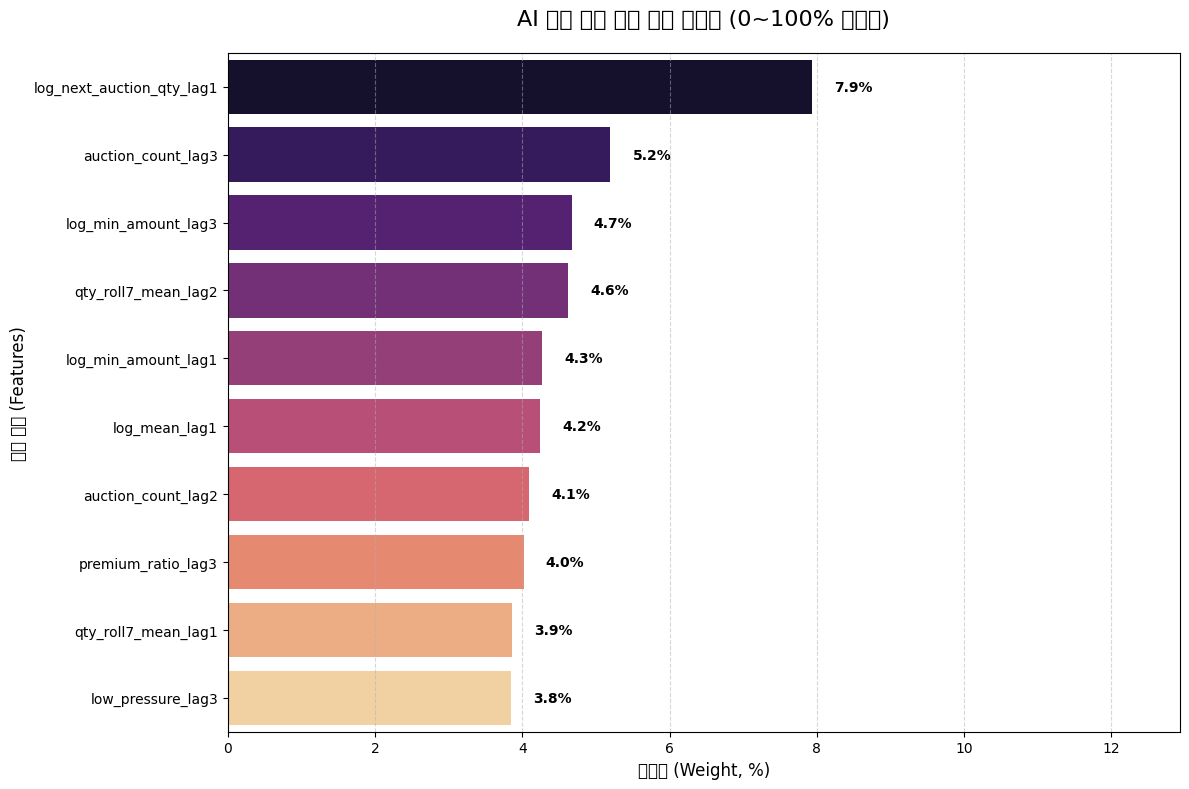

In [14]:
# 특정 모델(예: 최고가 Max 모델)의 중요도 추출
# MultiOutputRegressor의 3번째(index 2) 모델이 최고가 모델
max_price_model = model.estimators_[2]

# 중요도 점수 가져오기
raw_importance = max_price_model.feature_importances_

# [핵심] 가중치(%)로 변환 (전체 합을 100으로 정규화)
# 0~6과 같은 낮은 점수를 0~100% 범위로 스케일링
importance_sum = np.sum(raw_importance)
normalized_importance = (raw_importance / importance_sum) * 100

# 데이터프레임 구성
# flat_feature_names는 [feature_lag3, feature_lag2, feature_lag1...] 형태의 전체 피처 리스트
fi_df = pd.DataFrame({
    'feature_name': flat_feature_names,
    'weight': normalized_importance
})

# 상위 10개 피처 정렬
top_10_fi = fi_df.sort_values(by='weight', ascending=False).head(10)

# 시각화 (X축을 0~100% 범위로 설정)
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="weight", y="feature_name", data=top_10_fi, palette='magma')

# X축 범위를 0부터 시작하도록 설정 (최대값은 데이터에 맞춰 자동 조절되거나 100으로 고정 가능)
plt.xlim(0, max(top_10_fi['weight']) + 5) 

# 타이틀 및 라벨 설정
plt.title("AI 가격 결정 핵심 요인 가중치 (0~100% 스케일)", fontsize=16, pad=20)
plt.xlabel("가중치 (Weight, %)", fontsize=12)
plt.ylabel("핵심 피처 (Features)", fontsize=12)

# 각 막대 끝에 퍼센트 수치 표시
for i, v in enumerate(top_10_fi['weight']):
    ax.text(v + 0.3, i, f"{v:.1f}%", color='black', va='center', fontweight='bold')

plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [15]:
# 1. 2026년 전체 시즌 예측 데이터 저장
# (UI에서 그래프를 그리거나 시계열 흐름을 보여줄 때 사용)
df_2026.to_csv('forecast_2026_total.csv', index=False, encoding='utf-8-sig')

# 2. 2025년 테스트 검증 상세 데이터 저장 
# (실제값 vs 예측값 오차 분석용)
df_validation_detail.to_csv('validation_2025_detail.csv', index=False, encoding='utf-8-sig')

# 3. 피처 엔지니어링이 완료된 전체 학습 데이터 저장
# (나중에 다른 모델을 학습시키거나 데이터 구조 확인용)
df_std.to_csv('engineered_flower_data.csv', index=False, encoding='utf-8-sig')

print("✅ 모든 데이터가 CSV 파일로 성공적으로 저장되었습니다.")

✅ 모든 데이터가 CSV 파일로 성공적으로 저장되었습니다.
